# Optimiser son code

In [76]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline


def eval_pixel(row, col, grid, next_grid):
    """Follows the rules of Conway's game of life to
    flip (or not) a pixel in a grid
    """
    n, m = grid.shape
    sub_grid = grid[
        max(row-1, 0): min(n, row+2),
        max(col-1, 0): min(m, col+2)]
    if grid[row, col] and not (2 < sub_grid.sum() < 5):
        next_grid[row, col] = 0
    elif sub_grid.sum() == 3:
        next_grid[row, col] = 1


def conway_step(grid):
    """Applies Conway's rule for every pixel on a grid
    """
    ii, jj = np.meshgrid(
        np.arange(grid.shape[0]),
        np.arange(grid.shape[1]) )

    next_grid = grid.copy()
    for i, j in zip(ii.ravel(), jj.ravel()):
        eval_pixel(i, j, grid, next_grid)
    return next_grid


def conway_loop(grid, ax=None):
    """Play Conways game of life on repeat
    """
    
    while True:
        try:
            grid = conway_step(grid)
            fig, ax = show_conway(grid, None)
            time.sleep(1)

        except KeyboardInterrupt:
            print('Done')
            break

def show_conway(grid, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        fig.clear()
        
    im = ax.imshow(grid, cmap='Greys')
    ax.set_axis_off()
    
    return fig, ax

grid_shape = 100, 100

grid = np.random.randint(0, 2, size=grid_shape, dtype=np.uint8)
#grid[1:4, 3] = 1



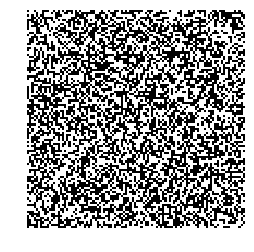

In [77]:
fig, ax = show_conway(grid)

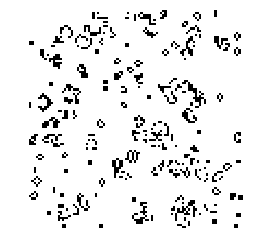

In [126]:
grid = conway_step(grid)
fig, ax = show_conway(grid)

## [Cython](https://docs.cython.org)

## [Numba](https://numba.pydata.org/)

## [Threading](https://docs.python.org/3.7/tutorial/stdlib2.html#multi-threading)

In [127]:
import threading

In [294]:
class ConwayStep(threading.Thread):
    def __init__(self, block, grid, next_grid):
        threading.Thread.__init__(self)
        self.block = block
        self.grid = grid
        self.next_grid = next_grid
        
    def run(self):
        start_i, stop_i, start_j, stop_j = self.block
        #print(f'running thred with start at {start_i, start_j}')
        ii, jj = np.meshgrid(
            np.arange(start_i, stop_i),
            np.arange(start_j, stop_j)
        )
        for i, j in zip(ii.ravel(), jj.ravel()):
            eval_pixel(i, j, self.grid, self.next_grid)



def parallel_step(grid, blocks):
    next_grid = grid.copy()

    threads = []
    for b in blocks:
        threads.append(ConwayStep(b, grid, next_grid))
    for th in threads:
        th.start()

    for th in threads:
        th.join()
    
    return next_grid
    


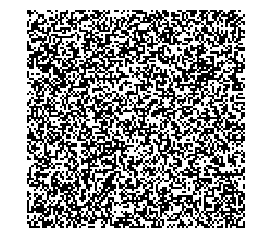

In [295]:
grid_shape = 100, 100
grid = np.random.randint(0, 2, size=grid_shape, dtype=np.uint8)
        

n, m = grid.shape
size_i = n // 2
size_j = m // 2


blocks = [
    (0, size_i, 0, size_j),
    (size_i, n, 0, size_j),
    (0, size_i, size_j, m),
    (size_i, n, size_j, m)
]



fig, ax = show_conway(grid)

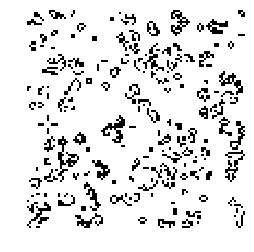

In [329]:
grid = parallel_step(grid, blocks)
fig, ax = show_conway(grid)


In [270]:
%timeit parallel_step(grid, blocks)

120 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [271]:
%timeit conway_step(grid)

115 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Multiprocessing

In [272]:
from multiprocessing import Process
import os

def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def f(name):
    info('function f')
    print('hello', name)

info('main line')
p = Process(target=f, args=('bob',))
p.start()
p.join()

main line
module name: __main__
parent process: 10708
process id: 14299
function f
module name: __main__
parent process: 14299
process id: 5182
hello bob


### No (trivialy) shared data!!

In [292]:
class ConwayStep_mp(Process):
    def __init__(self, block, grid, next_grid):
        Process.__init__(self)
        self.block = block
        self.grid = grid
        self.next_grid = next_grid
        
    def run(self):
        start_i, stop_i, start_j, stop_j = self.block
        #print(f'running thred with start at {start_i, start_j}')
        ii, jj = np.meshgrid(
            np.arange(start_i, stop_i),
            np.arange(start_j, stop_j)
        )
        for i, j in zip(ii.ravel(), jj.ravel()):
            eval_pixel(i, j, self.grid, self.next_grid)


def parallel_step_mp(grid, blocks):
    next_grid = grid.copy()

    processes = []
    for b in blocks:
        processes.append(ConwayStep_mp(b, grid, next_grid))
    for th in processes:
        th.start()

    for th in processes:
        th.join()
    
    return next_grid
    


In [279]:
%timeit parallel_step_mp(grid, blocks)

85.7 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


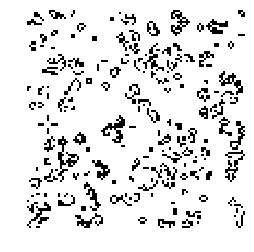

In [334]:
grid = parallel_step_mp(grid, blocks)
fig, ax = show_conway(grid)